# Module 2. 학습 및 테스트 데이터 세트 분류

## Library Import 

파이썬에는 광범위한 라이브러리 모음이 포함되어 있으며, 본 LAB을 위해서 핵심 Data Scientist용 Tool 인 boto3 (AWS SDK) 및 Pandas/Numpy와 같은 라이브러리를 가져와야 합니다. 

In [1]:
# Imports
import boto3
import json
import numpy as np
import pandas as pd
import time
import os

from datetime import datetime
import sagemaker
import time
import warnings

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate
from botocore.exceptions import ClientError

다음으로 여러분의 환경이 Amazon Personalize와 성공적으로 통신할 수 있는지 확인해야 합니다.

In [2]:
# Configure the SDK to Personalize:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')
s3 = boto3.resource('s3')

이전에 저장했던 파라미터를 불러오기 옵니다

In [3]:
%store -r

### 파일 읽어 오기 

In [4]:
df=pd.read_csv(inter_file)
item=pd.read_csv(item_file)
user=pd.read_csv(user_file)

## Cold Dataset 파악하기 

User personalization은 신규아이템 생성 시간을 기준으로 콜드 아이템 추천하는 기간을 추정합니다.<br/>
만약 Item Metadata 세에 생성 타임 스탬프가 없을 경우에는 해당 아이템이 처음 인터렉션이 발생하는 시간을 생성 날짜로 사용합니다. <br/>
지금 제공하는 샘플 데이터 셋에는 메타 데이터에는 생성 타임 스탬프가 없기 때문에 인터렉션 시간을 기준으로 유추하게 됩니다. <br/>
자세한 내용은 [여기](https://docs.aws.amazon.com/ko_kr/personalize/latest/dg/creation-timestamp-data.html)를
 클릭해 봅니다. 
 
여기서는 아이템 첫 인터렉션을 기준으로 월별 신규 아이템 수를 분석해 봅니다.


### Update the timestamp

이번 실습에서 사용되는 데이터 세트는 2000년 4월 25일 부터 12월 30일가지의 데이터 세트 입니다.
Personalize는 item의 생성 타임 스탬프가 없을경우 인터렉션이 처음 생성된 타임 스탬프를 기준으로 하게 됩니다.
https://docs.aws.amazon.com/personalize/latest/dg/creation-timestamp-data.html

Cold Item 테스트를 위해 모든 데이터 세트를 최신 데이터 세트 기준으로 바꾸도록 합니다.

In [5]:
## Check Min/Max Time in interaction dataset
print("from",datetime.utcfromtimestamp(df['TIMESTAMP'].min()).strftime('%Y-%m-%d %H:%M:%S'), "to", datetime.utcfromtimestamp(df['TIMESTAMP'].max()).strftime('%Y-%m-%d %H:%M:%S') )

from 2000-04-25 23:05:32 to 2000-12-30 23:59:03


In [6]:
# Get the time gap between the latest timestamp in the interaction and the current time 
current_time = int(time.time())
df = df.astype({"TIMESTAMP": 'int64'})
latest_time_in_csv = df["TIMESTAMP"].max()
delta = current_time- latest_time_in_csv

In [7]:
# shift the latest timestamp in the interactions_df to be the last hour timestamp
df.TIMESTAMP = df.TIMESTAMP + delta

In [8]:

## Check shifted Min/Max Time in interaction dataset
print("from",datetime.utcfromtimestamp(df['TIMESTAMP'].min()).strftime('%Y-%m-%d %H:%M:%S'), "to", datetime.utcfromtimestamp(df['TIMESTAMP'].max()).strftime('%Y-%m-%d %H:%M:%S') )


from 2020-04-11 06:11:26 to 2020-12-16 07:04:57


### Daily New Item 개수 파악 하기

In [9]:
item_creation_time=df[["ITEM_ID","TIMESTAMP"]].groupby('ITEM_ID').min()
item_creation_time['TIMESTAMP'] =pd.to_datetime(item_creation_time['TIMESTAMP'], unit='s')
item_creation_time.head()

,TIMESTAMP
ITEM_ID,
1,2020-04-11 08:40:03
2,2020-04-11 10:26:32
3,2020-04-11 13:55:14
4,2020-04-12 12:36:50
5,2020-04-13 08:24:36


In [10]:
daily_new_item=item_creation_time.reset_index().groupby(pd.Grouper(key='TIMESTAMP',freq='D')).count().rename(columns={'ITEM_ID':"ITEM_COUNT"})
assert(daily_new_item['ITEM_COUNT'].sum()==len(df['ITEM_ID'].unique()))
daily_new_item

,ITEM_COUNT
TIMESTAMP,
2020-04-11,1240
2020-04-12,269
2020-04-13,218
2020-04-14,162
2020-04-15,55
...,...
2020-12-11,1
2020-12-12,1
2020-12-13,1


In [11]:
#최근 100일동안 콜드 아이템 평균 개수
daily_new_item[-100:]['ITEM_COUNT'].sum()/len(daily_new_item[-100:])

1.72

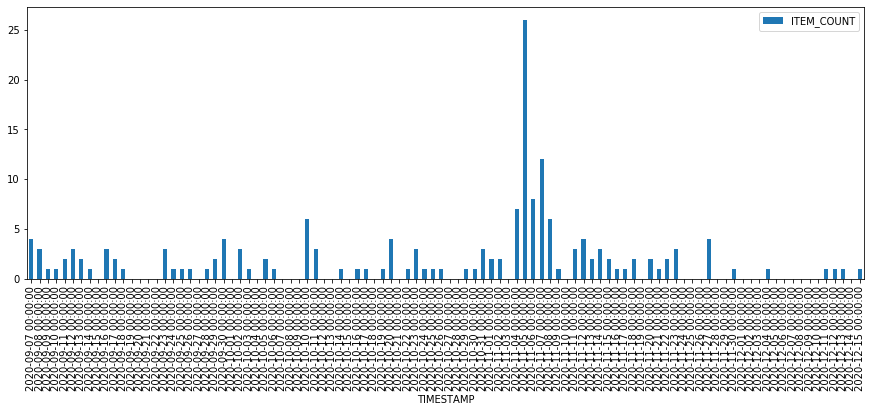

In [12]:
#최근 100일 동안의 Cold item 생성 결과
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate
daily_new_item[-100:].plot(kind='bar',figsize=(15,5))
plt.show()

## Train/Test 데이터 셋 분리하기 
여기에서는 일부 데이터를 테스트 용으로 분리하도록 합니다.
테스트 셋은 콜드 아이템이 충분히 포함 될수 있도록 약 40일 이전 부터 최근까지의 데이터를 사용할 예정입니다.

In [13]:
print("from",datetime.utcfromtimestamp(df['TIMESTAMP'].min()).strftime('%Y-%m-%d %H:%M:%S'), "to", datetime.utcfromtimestamp(df['TIMESTAMP'].max()).strftime('%Y-%m-%d %H:%M:%S') )

from 2020-04-11 06:11:26 to 2020-12-16 07:04:57


In [14]:
test_start= current_time - 40*24*60*60
print(test_start)
df_train=df[df['TIMESTAMP']<test_start]
df_test=df[df['TIMESTAMP']>=test_start]
df_train.info()
df_test.info()

1604646297
<class 'pandas.core.frame.DataFrame'>
Int64Index: 554919 entries, 161261 to 755778
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   USER_ID      554919 non-null  int64 
 1   ITEM_ID      554919 non-null  int64 
 2   EVENT_VALUE  554919 non-null  int64 
 3   TIMESTAMP    554919 non-null  int64 
 4   EVENT_TYPE   554919 non-null  object
dtypes: int64(4), object(1)
memory usage: 25.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200860 entries, 0 to 749831
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   USER_ID      200860 non-null  int64 
 1   ITEM_ID      200860 non-null  int64 
 2   EVENT_VALUE  200860 non-null  int64 
 3   TIMESTAMP    200860 non-null  int64 
 4   EVENT_TYPE   200860 non-null  object
dtypes: int64(4), object(1)
memory usage: 9.2+ MB


### Cold / Warm item 분리하기 
Test 셋 데이터에는 이전에부터 인터렉션 아이템과 콜드 아이템이 모두 존재 합니다.
여기에서는 테스트 데이터 셋안의 콜드 아이템만 분리하도록 합니다.
또한 이후 테스트를 위해 Test 데이터 셋트 안의 old user들만을 분리하도록 합니다.


In [15]:
unique_items = df['ITEM_ID'].unique()
print("The number of Total_items:", len(unique_items))
warm_items = df_train['ITEM_ID'].unique()
unique_items_in_test=df_test['ITEM_ID'].unique()
cold_items=[item for item in unique_items_in_test if item not in warm_items]
print("The number of Warm_items: {}".format(len(warm_items)))
print("The number of Cold_items: {}".format(len(cold_items)))

The number of Total_items: 3590
The number of Warm_items: 3529
The number of Cold_items: 61


In [16]:
#Create metadata with only items in the interaction
item_meta_warm=item[item['ITEM_ID'].isin(warm_items)]
item_train=item_meta_warm.drop(['TITLE'],axis=1)

#Create metadata with only items in the interaction
item_meta_cold=item[item['ITEM_ID'].isin(cold_items)]

In [17]:
unique_user_from_train=df_train['USER_ID'].unique()
user_train=user[user['USER_ID'].isin(unique_user_from_train)]

## 학습 데이터 타입 변경 및 파일 저장 하기  


In [18]:

#Interaction Data 

df_train.EVENT_VALUE = df_train.EVENT_VALUE.astype(float)
df_train.ITEM_ID = df_train.ITEM_ID.astype(str)
df_train.USER_ID = df_train.USER_ID.astype(str)
df_train.TIMESTAMP=df_train.TIMESTAMP.astype('int64')
df_train.EVENT_TYPE=df_train.EVENT_TYPE.astype(str)

#User Data
user.USER_ID = user.USER_ID.astype(str)
user.GENDER=user.GENDER.astype(str)
user.AGE=user.AGE.astype(str)
user.OCCUPATION=user.OCCUPATION.astype(str)

user_train.USER_ID = user_train.USER_ID.astype(str)
user_train.GENDER= user_train.GENDER.astype(str)
user_train.AGE=user_train.AGE.astype(str)
user_train.OCCUPATION=user_train.OCCUPATION.astype(str)

#Item Data
item_train.ITEM_ID=item_train.ITEM_ID.astype(str)
item_train.GENRE=item_train.GENRE.astype(str)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [19]:

data_path=data_dir+"/"+WORK_DATE

item_train_file=data_path+'/'+'item_train.csv'
item_warm_file=data_path+'/'+'item_warm.csv'
item_cold_file=data_path+'/'+'item_cold.csv'

interaction_train_file=data_path+'/'+'interation_train.csv'
interaction_test_file=data_path+'/'+'interation_test.csv'
interaction_all_file=data_path+'/'+'df_all.csv'

user_train_file=data_path+'/'+'user_train.csv'

item_train.to_csv(item_train_file,index=False)
item_meta_warm.to_csv(item_warm_file,index=False)
item_meta_cold.to_csv(item_cold_file,index=False)

df_train.to_csv(interaction_train_file, index=False)
df_test.to_csv(interaction_test_file,index=False)
df.to_csv(interaction_all_file,index=False)

user_train.to_csv(user_train_file,index=False)


In [20]:
print("from",datetime.utcfromtimestamp(df_train['TIMESTAMP'].min()).strftime('%Y-%m-%d %H:%M:%S'), "to", datetime.utcfromtimestamp(df_train['TIMESTAMP'].max()).strftime('%Y-%m-%d %H:%M:%S') )

from 2020-04-11 06:11:26 to 2020-11-06 07:04:54


In [21]:
print("-----Test Data------")
print("from",datetime.utcfromtimestamp(df_test['TIMESTAMP'].min()).strftime('%Y-%m-%d %H:%M:%S'), "to", datetime.utcfromtimestamp(df_test['TIMESTAMP'].max()).strftime('%Y-%m-%d %H:%M:%S') )

-----Test Data------
from 2020-11-06 07:04:57 to 2020-12-16 07:04:57


In [22]:
%store item_train_file
%store item_warm_file
%store item_cold_file
%store interaction_train_file
%store interaction_test_file
%store interaction_all_file
%store user_train_file


Stored 'item_train_file' (str)
Stored 'item_warm_file' (str)
Stored 'item_cold_file' (str)
Stored 'interaction_train_file' (str)
Stored 'interaction_test_file' (str)
Stored 'interaction_all_file' (str)
Stored 'user_train_file' (str)
